# Import Dataset

In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import sklearn
import pickle

In [2]:
folder_path = "images"

# Load Image and Labels

In [3]:
def load_image(image_path):
  image = cv2.imread(image_path)
  if image is None:
    print('Error: Could not load image.')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image, gray

In [4]:
dataset_dir = '/content/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image = load_image(os.path.join(root, f))
    if image is None:
      continue
    images.append(image)
    labels.append(root.split('/')[-1])

In [5]:
sample_image, sample_gray = load_image("Users/sharla/Downloads/images/Sharla_Raissa/Sharla_Raissa_0001.jpeg")

(np.float64(-0.5), np.float64(1199.5), np.float64(1598.5), np.float64(-0.5))

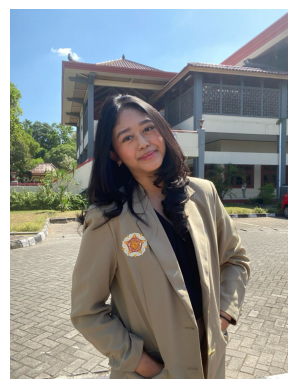

In [6]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)
plt.axis("off")

(np.float64(-0.5), np.float64(1199.5), np.float64(1598.5), np.float64(-0.5))

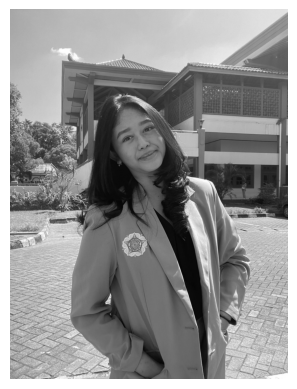

In [7]:
plt.imshow(sample_gray, cmap='gray')
plt.axis('off')              

In [9]:
dataset_dir = '/Users/sharla/Downloads/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  print(root, dirs, files)
  if len(files) == 0:
    continue
  for f in files:
    _, image = load_image(os.path.join(root, f))
    if image is None:
      continue
    images.append(image)
    labels.append(root.split('/')[-1])

/Users/sharla/Downloads/images ['Sharla_Raissa', 'Carlos_Moya', 'Vladimir_Putin', 'Laura_Bush', 'George_W_Bush', 'Nabila_Yumna', 'Serena_Williams'] ['.DS_Store']
Error: Could not load image.
/Users/sharla/Downloads/images/Sharla_Raissa [] ['Sharla_Raissa_0005.jpeg', 'Sharla_Raissa_0009.jpeg', '.DS_Store', 'Sharla_Raissa_0008.jpeg', 'Sharla_Raissa_0004.jpeg', 'Sharla_Raissa_0003.jpeg', 'Sharla_Raissa_0002.jpeg', 'Sharla_Raissa_0001.jpeg', 'Sharla_Raissa_0007.jpeg', 'Sharla_Raissa_0010.jpeg', 'Sharla_Raissa_0006.jpeg']
Error: Could not load image.
/Users/sharla/Downloads/images/Carlos_Moya [] ['Carlos_Moya_0004.jpg', 'Carlos_Moya_0010.jpg', 'Carlos_Moya_0005.jpg', 'Carlos_Moya_0007.jpg', 'Carlos_Moya_0006.jpg', 'Carlos_Moya_0002.jpg', '.DS_Store', 'Carlos_Moya_0003.jpg', 'Carlos_Moya_0001.jpg', 'Carlos_Moya_0008.jpg', 'Carlos_Moya_0009.jpg']
Error: Could not load image.
/Users/sharla/Downloads/images/Vladimir_Putin [] ['8.jpg', '9.jpg', '10.jpg', '4.jpg', '5.jpg', '7.jpg', '6.jpg', '2.jp

In [10]:
len(labels)

70

#Face Detection

In [11]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

[ERROR:0@82.732] global persistence.cpp:566 open Can't open file: 'haarcascade_frontalface_default.xml' in read mode


In [19]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces


In [21]:
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

In [22]:
sample_face = detect_faces(sample_gray)

(np.float64(-0.5), np.float64(266.5), np.float64(266.5), np.float64(-0.5))

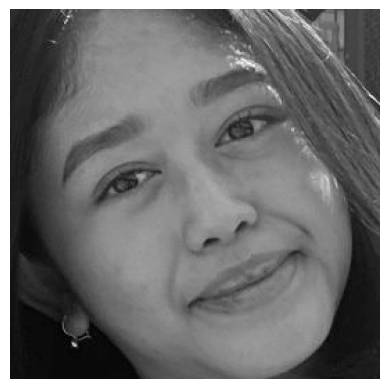

In [23]:
sample_image_face, _ = crop_faces(sample_gray, sample_face)
plt.imshow(sample_image_face[0], cmap='gray')
plt.axis("off")

#Face Recognition

In [24]:
face_size = (128, 128)
def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

In [25]:
X = []
y = []

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y)

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
  ])

In [29]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Carlos_Moya       0.50      0.33      0.40         3
  George_W_Bush       0.25      0.33      0.29         3
     Laura_Bush       1.00      0.67      0.80         3
   Nabila_Yumna       1.00      0.33      0.50         3
Serena_Williams       1.00      0.67      0.80         3
  Sharla_Raissa       0.33      0.67      0.44         3
 Vladimir_Putin       0.25      0.33      0.29         3

       accuracy                           0.48        21
      macro avg       0.62      0.48      0.50        21
   weighted avg       0.62      0.48      0.50        21



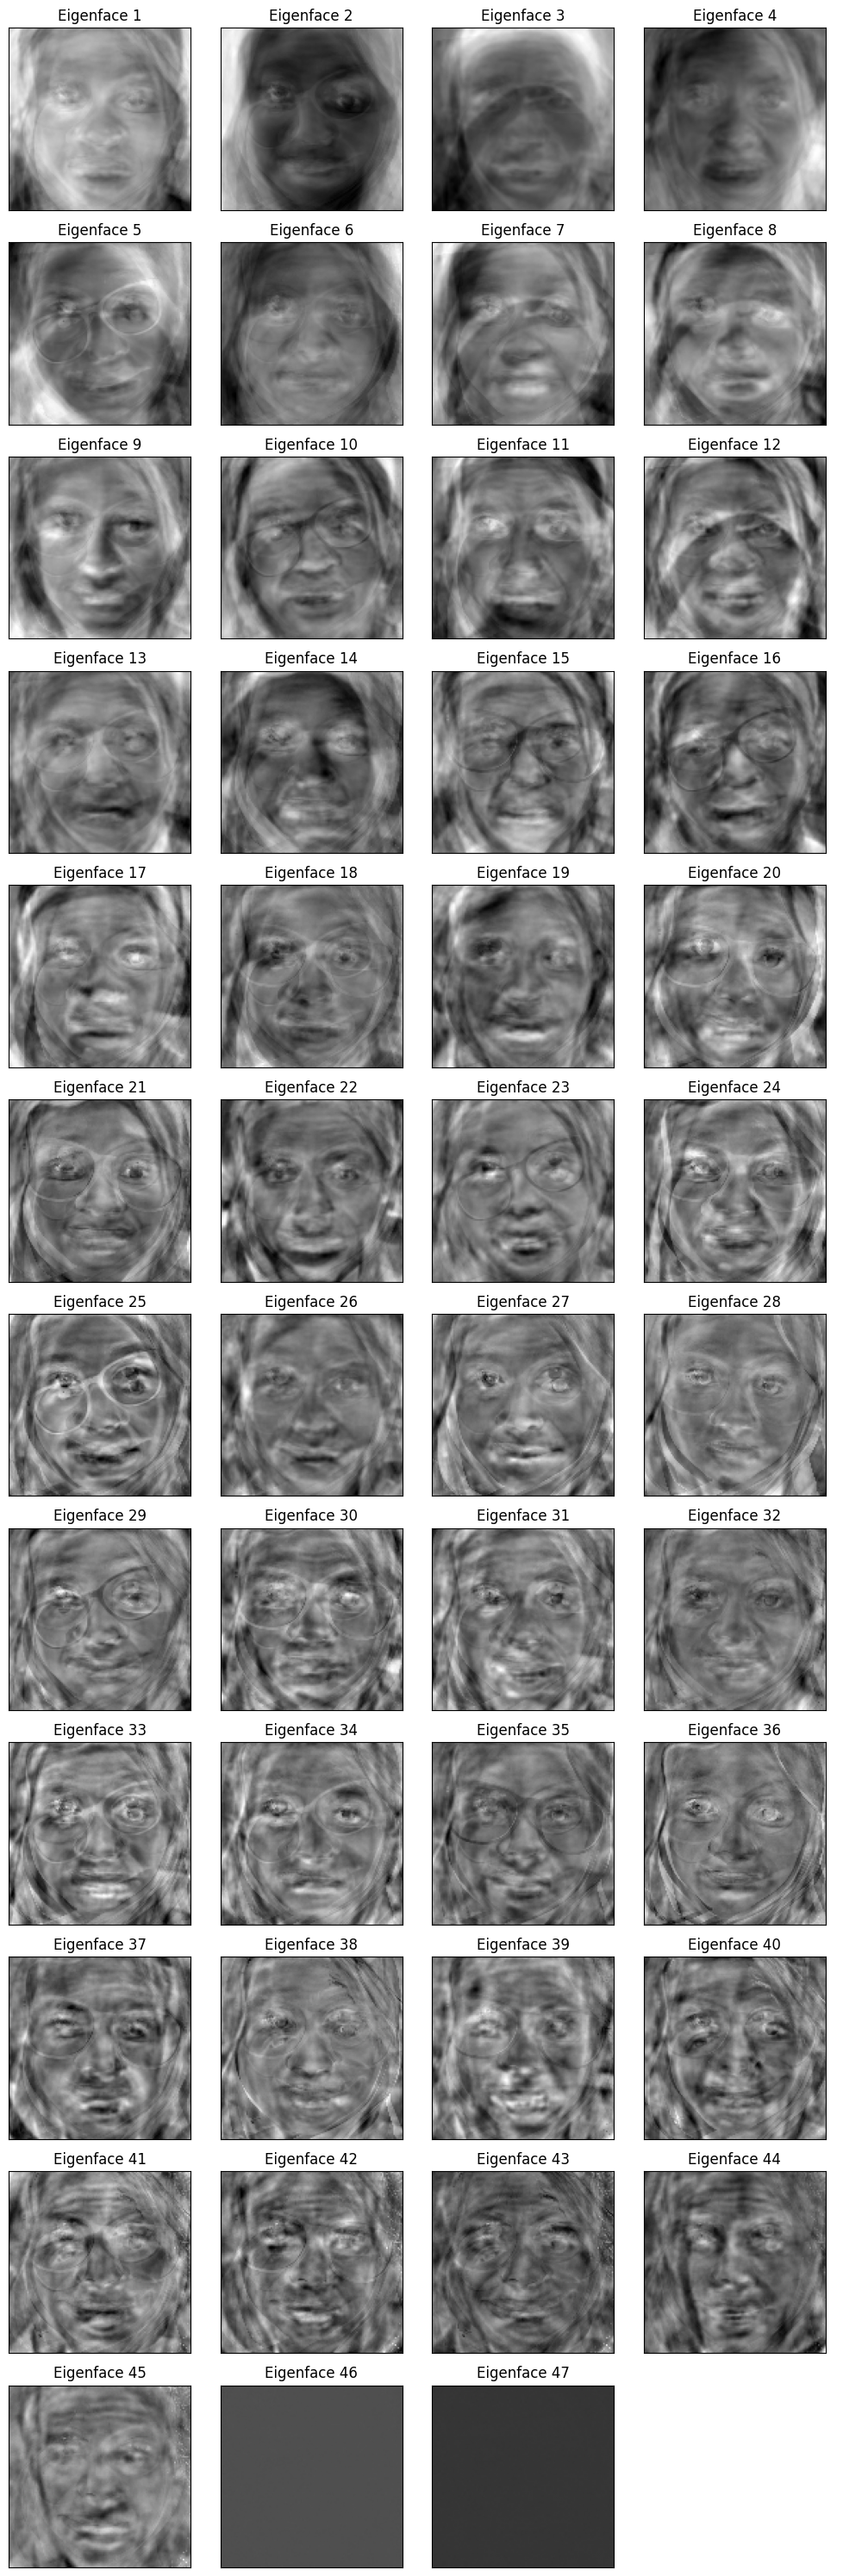

In [34]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))
for i, ax in enumerate(axes.flat):
    if i < len(eigenfaces):
        ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

In [38]:
with open('/tmp/eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)


In [39]:
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [40]:
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)
  if len(cropped_faces) == 0:
    return 'No face detected.'

  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)

  X_face = np.array(X_face)
  labels = pipe.predict(X_face)
  scores = get_eigenface_score(X_face)
  return scores, labels, selected_faces

In [41]:
sample_score, sample_labels, sample_face = eigenface_prediction(sample_gray)

In [42]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
              ):
  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

In [43]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    draw_text(result_image, label, score, pos=(x, y))
    return result_image

(np.float64(-0.5), np.float64(1199.5), np.float64(1598.5), np.float64(-0.5))

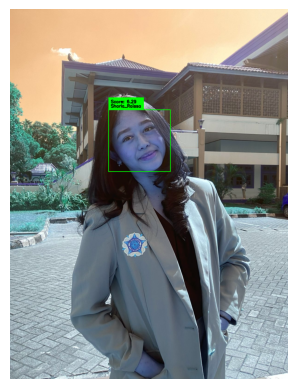

In [44]:
result = draw_result(sample_image, sample_score, sample_labels, sample_face)
plt.imshow(result)
plt.axis("off")

# Real-Time Face Recognition

In [50]:
cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    result = eigenface_prediction(gray)
    print(result)

    if isinstance(result, tuple):
        if len(result) == 3:
            scores, labels, coords = result 
        elif len(result) == 2:
            scores, labels = result 
            coords = [] 
        else:
            print("Unexpected number of values returned by eigenface_prediction!")
            continue
    else:
        print("Invalid result format!")
        continue

    if isinstance(scores, str):
        cv2.putText(frame, scores, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 0, 255), 2)
    else:
        frame = draw_result(frame, scores, labels, coords)

    cv2.imshow('Real-Time Face Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

(array([6.24249679]), array(['Nabila_Yumna'], dtype='<U15'), [(np.int32(525), np.int32(125), np.int32(350), np.int32(350))])
(array([6.24044036]), array(['Nabila_Yumna'], dtype='<U15'), [(np.int32(528), np.int32(130), np.int32(343), np.int32(343))])
(array([6.24226227]), array(['Nabila_Yumna'], dtype='<U15'), [(np.int32(527), np.int32(128), np.int32(343), np.int32(343))])
(array([6.33333333]), array(['Sharla_Raissa'], dtype='<U15'), [(np.int32(532), np.int32(131), np.int32(337), np.int32(337))])
(array([6.33333333]), array(['Sharla_Raissa'], dtype='<U15'), [(np.int32(528), np.int32(128), np.int32(340), np.int32(340))])
(array([6.33333333]), array(['Sharla_Raissa'], dtype='<U15'), [(np.int32(529), np.int32(130), np.int32(339), np.int32(339))])
(array([6.33333333]), array(['Sharla_Raissa'], dtype='<U15'), [(np.int32(532), np.int32(133), np.int32(334), np.int32(334))])
(array([6.33333333]), array(['Sharla_Raissa'], dtype='<U15'), [(np.int32(531), np.int32(131), np.int32(339), np.int32(339

KeyboardInterrupt: 